# The Mighty Thymio: Sensors

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import rospy

In [4]:
import rosnode
import rostopic
import rosmsg

In [5]:
import std_msgs.msg
import sensor_msgs.msg
import nav_msgs.msg

In [6]:
rospy.init_node('notebook')

In [18]:
def print_msg_definition(msg_type):
    print(rosmsg.get_msg_text(msg_type))

In [19]:
def print_first_message(topic, msg_type, number_of_messages=1, max_size=None):
    print("Let's print the first message[s]:\n")
    _ns = [number_of_messages]
    def callback(msg):
        _ns[0] -= 1
        if max_size:
            fmt = '%.{0}s ...'.format(max_size)
            print(fmt % msg)
        else:
             print(msg)
        if _ns[0] == 0:
            print('\nand then unsubscribe.')
            sub.unregister()
    sub = rospy.Subscriber(topic, msg_type, callback)

In [148]:
start_time = rospy.Time.now()

In [153]:
dt = (rospy.Time.now() - start_time)

In [154]:
dt.

31.421600819

In [158]:
def collect_msgs(topic, msg_type, duration=1):
    start_time = rospy.Time.now()
    msgs = []
    def callback(msg):
        msgs.append(msg)        
    sub = rospy.Subscriber(topic, msg_type, callback)
    rospy.sleep(duration)
    sub.unregister() 
    return msgs

# [Raw] Aseba Messages

Aseba message are of two types: 
    - asebaros_msgs/AsebaEvent 
    - asebaros_msgs/AsebaAnonymousEvent

In [20]:
for msg_type in rosmsg.list_msgs('asebaros_msgs'):
    print('\n------- %s -------' % msg_type)
    print('Format:\n%s' % rosmsg.get_msg_text(msg_type))
    print('Topics:\n%s' % '\n'.join(rostopic.find_by_type(msg_type)))


------- asebaros_msgs/AsebaAnonymousEvent -------
Format:
time stamp
uint16 source
uint16 type
int16[] data

Topics:
/aseba/anonymous_events

------- asebaros_msgs/AsebaEvent -------
Format:
time stamp
uint16 source
int16[] data

Topics:
/aseba/events/set_speed
/aseba/events/ground_ambient
/aseba/events/buttons
/aseba/events/set_led_bottom_left
/aseba/events/ground_reflected
/aseba/events/play_sound
/aseba/events/sound
/aseba/events/button_left
/aseba/events/tap
/aseba/events/temperature
/aseba/events/play_system_sound
/aseba/events/button_forward
/aseba/events/remote
/aseba/events/button_backward
/aseba/events/shutdown
/aseba/events/proximity
/aseba/events/set_comm
/aseba/events/comm
/aseba/events/ground
/aseba/events/set_led_top
/aseba/events/set_led_bottom_right
/aseba/events/accelerometer
/aseba/events/set_led_gesture
/aseba/events/set_led
/aseba/events/set_sound_threshold
/aseba/events/button_center
/aseba/events/odometry
/aseba/events/button_right


In [22]:
import asebaros_msgs.msg

rospy.wait_for_message('/aseba/events/proximity', asebaros_msgs.msg.AsebaEvent)

stamp: 
  secs: 1519388324
  nsecs: 415653175
source: 1
data: [0, 0, 0, 0, 0, 0, 0]

# Sensors

## Proximity Sensors

Data from proximity sensors are of type sensor_msgs/Range

In [23]:
print(rosmsg.get_msg_text("sensor_msgs/Range"))

uint8 ULTRASOUND=0
uint8 INFRARED=1
std_msgs/Header header
  uint32 seq
  time stamp
  string frame_id
uint8 radiation_type
float32 field_of_view
float32 min_range
float32 max_range
float32 range



In [24]:
rostopic.find_by_type('sensor_msgs/Range')

['/proximity/center_right',
 '/ground/right',
 '/ground/left',
 '/proximity/center',
 '/proximity/rear_left',
 '/proximity/left',
 '/proximity/rear_right',
 '/proximity/right',
 '/proximity/center_left']

There are 5 proximity sensor on the front
     - `/proximity/left`,
     - `/proximity/center_left`
     - `/proximity/center`
     - `/proximity/center_right`
     - `/proximity/right`)
2 on the back
    - `/proximity/rear_left`
    - `/proximity/rear_right`
and  2 pointing down
    - `/ground/right`
    - `/ground/right`

In [27]:
rospy.wait_for_message('/proximity/center', sensor_msgs.msg.Range)

header: 
  seq: 1229
  stamp: 
    secs: 1519388356
    nsecs:  59273004
  frame_id: "proximity_center_link"
radiation_type: 1
field_of_view: 0.300000011921
min_range: 0.0215000007302
max_range: 0.140000000596
range: inf

Collect few seconds of proximity sensors:

In [173]:
msgs = collect_msgs('/proximity/center', sensor_msgs.msg.Range, 10)

In [174]:
data = np.array([(msg.header.stamp.to_sec(), msg.range) for msg in msgs])

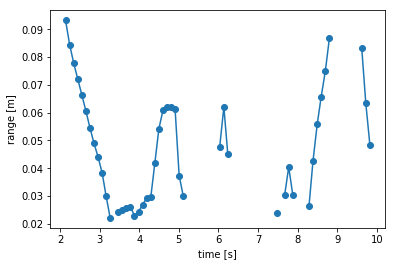

In [175]:
plt.plot(data[:,0] - data[0,0], data[:,1], 'o-')
plt.xlabel('time [s]');
plt.ylabel('range [m]');

## Buttons

The buttons state is periodically published as an aggregate `sensor_msgs/Joy` message 

In [28]:
print(rostopic.get_topic_type('/buttons')[0])

sensor_msgs/Joy


In [29]:
print(rosmsg.get_msg_text('sensor_msgs/Joy'))

std_msgs/Header header
  uint32 seq
  time stamp
  string frame_id
float32[] axes
int32[] buttons



In [30]:
rospy.wait_for_message('buttons', sensor_msgs.msg.Joy)

header: 
  seq: 1
  stamp: 
    secs: 1519388375
    nsecs: 980694055
  frame_id: ''
axes: []
buttons: [0, 0, 0, 0, 0]

When the state of individual buttons is changed, an `std_msgs/Bool` is published:

In [31]:
rospy.get_published_topics('/buttons')

[['/buttons/backward', 'std_msgs/Bool'],
 ['/buttons/right', 'std_msgs/Bool'],
 ['/buttons/left', 'std_msgs/Bool'],
 ['/buttons/forward', 'std_msgs/Bool'],
 ['/buttons/center', 'std_msgs/Bool']]

In [36]:
(rospy.wait_for_message('/buttons/forward', std_msgs.msg.Bool), 
 rospy.wait_for_message('/buttons/forward', std_msgs.msg.Bool))

(data: True, data: False)

# Camera

The camera driver publishes two types of topics.

`/camera/camera_info` contains the informaion about the image size and the lens distortion.

In [37]:
print(rostopic.get_topic_type('/camera/camera_info')[0])

sensor_msgs/CameraInfo


In [38]:
print_msg_definition('sensor_msgs/CameraInfo')

std_msgs/Header header
  uint32 seq
  time stamp
  string frame_id
uint32 height
uint32 width
string distortion_model
float64[] D
float64[9] K
float64[9] R
float64[12] P
uint32 binning_x
uint32 binning_y
sensor_msgs/RegionOfInterest roi
  uint32 x_offset
  uint32 y_offset
  uint32 height
  uint32 width
  bool do_rectify



The other topics provide the (optionally compressed) camera images
    `camera/image_raw[/compressed|/theora]`

In [39]:
for compr in ['', '/compressed', '/theora']:
    topic = '/camera/image_raw%s' % compr
    msg_type = rostopic.get_topic_type(topic)[0]
    print('%s: %s' % (topic, msg_type))

/camera/image_raw: sensor_msgs/Image
/camera/image_raw/compressed: sensor_msgs/CompressedImage
/camera/image_raw/theora: theora_image_transport/Packet


In [40]:
print_msg_definition('sensor_msgs/Image')

std_msgs/Header header
  uint32 seq
  time stamp
  string frame_id
uint32 height
uint32 width
string encoding
uint8 is_bigendian
uint32 step
uint8[] data



In [41]:
print_msg_definition('sensor_msgs/CompressedImage')

std_msgs/Header header
  uint32 seq
  time stamp
  string frame_id
string format
uint8[] data



In [133]:
data_msg = rospy.wait_for_message('/camera/image_raw', sensor_msgs.msg.Image)
format_msg = rospy.wait_for_message('camera/camera_info', sensor_msgs.msg.CameraInfo)

In [134]:
format_msg

header: 
  seq: 54868
  stamp: 
    secs: 1519389499
    nsecs:  31495097
  frame_id: "camera_link"
height: 480
width: 640
distortion_model: "plumb_bob"
D: [-0.003061, 0.04469099999999999, 0.012541, -0.0008579999999999999, 0.0]
K: [771.759661, 0.0, 334.870293, 0.0, 776.997516, 281.09781, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [776.809204, 0.0, 333.889638, 0.0, 0.0, 775.952881, 284.525498, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 0
binning_y: 0
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: False

In [135]:
pixels = np.fromstring(data_msg.data, dtype=np.dtype(np.uint8)).reshape(format_msg.height, format_msg.width, 3)

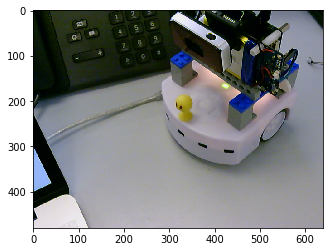

In [136]:
plt.imshow(pixels)

## (inter-robot) IR  communication
Robots can send to neighbors small chanks of 10 bits encoded as a `std_msgs/Int16`

In [69]:
print(rostopic.get_topic_type('/comm/receive')[0])

std_msgs/Int16


In [68]:
# rospy.wait_for_message('/camera/image_raw', std_msgs.msg.Int16)

Let's print the first message[s]:



## IMU

In [72]:
print_msg_definition('sensor_msgs/Imu')

std_msgs/Header header
  uint32 seq
  time stamp
  string frame_id
geometry_msgs/Quaternion orientation
  float64 x
  float64 y
  float64 z
  float64 w
float64[9] orientation_covariance
geometry_msgs/Vector3 angular_velocity
  float64 x
  float64 y
  float64 z
float64[9] angular_velocity_covariance
geometry_msgs/Vector3 linear_acceleration
  float64 x
  float64 y
  float64 z
float64[9] linear_acceleration_covariance



In [137]:
rospy.wait_for_message('/imu',sensor_msgs.msg.Imu)

header: 
  seq: 1
  stamp: 
    secs: 1519389554
    nsecs:  14442920
  frame_id: "base_link"
orientation: 
  x: 0.0
  y: 0.0
  z: 0.0
  w: 0.0
orientation_covariance: [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
angular_velocity: 
  x: 0.0
  y: 0.0
  z: 0.0
angular_velocity_covariance: [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
linear_acceleration: 
  x: 0.0
  y: -0.42652173913
  z: 9.81
linear_acceleration_covariance: [0.07, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.0, 0.07]

In [ ]:
## TODO: joint_states

In [74]:
# rospy.wait_for_message('/joint_states', sensor_msgs.msg.JointState)

Let's print the first message[s]:



# Odometry

In [80]:
print_msg_definition('nav_msgs/Odometry')

std_msgs/Header header
  uint32 seq
  time stamp
  string frame_id
string child_frame_id
geometry_msgs/PoseWithCovariance pose
  geometry_msgs/Pose pose
    geometry_msgs/Point position
      float64 x
      float64 y
      float64 z
    geometry_msgs/Quaternion orientation
      float64 x
      float64 y
      float64 z
      float64 w
  float64[36] covariance
geometry_msgs/TwistWithCovariance twist
  geometry_msgs/Twist twist
    geometry_msgs/Vector3 linear
      float64 x
      float64 y
      float64 z
    geometry_msgs/Vector3 angular
      float64 x
      float64 y
      float64 z
  float64[36] covariance



In [138]:
rospy.wait_for_message('/odom', nav_msgs.msg.Odometry)

header: 
  seq: 1
  stamp: 
    secs: 1519389565
    nsecs: 479753017
  frame_id: "odom"
child_frame_id: "base_link"
pose: 
  pose: 
    position: 
      x: -0.537234198032
      y: -0.164804682561
      z: 0.0
    orientation: 
      x: 0.0
      y: 0.0
      z: 0.401454892655
      w: 0.91587879611
  covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
twist: 
  twist: 
    linear: 
      x: -0.00170648464164
      y: 0.0
      z: 0.0
    angular: 
      x: 0.0
      y: 0.0
      z: 0.0
  covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
## TODO remote

## TODO sound

In [139]:
rospy.wait_for_message('/sound', std_msgs.msg.Float32)

data: 1.0

In [ ]:
## TODO Tap

In [140]:
rospy.wait_for_message('/tap', std_msgs.msg.Empty)

In [ ]:
#TODO temp

In [141]:
rospy.wait_for_message('/temperature', sensor_msgs.msg.Temperature)

header: 
  seq: 1
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: "base_link"
temperature: 29.3
variance: 0.01

In [ ]:
# TODO

# /ups/ac
# /ups/battery

In [142]:
rospy.wait_for_message('/ups/ac', std_msgs.msg.Bool)

data: True

In [143]:
rospy.wait_for_message('/ups/battery', std_msgs.msg.Bool)

data: True